In [1]:
# Basic imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns

In [2]:
# Scikit Learn imports and XGBoost

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import f1_score, accuracy_score

from xgboost import XGBClassifier

In [3]:
# Keras imports

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.metrics import Accuracy
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [4]:
data = []
with open('../data/raw/ultimate_data_challenge.json') as top_symbols:
    data = json.load(top_symbols)

In [5]:
users = pd.DataFrame(data)

In [6]:
users.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [7]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [8]:
# Assuming no duplicates

num_users = users.shape[0]

In [9]:
# Adjusting the type of certain columns

users.signup_date = pd.to_datetime(users.signup_date)
users.last_trip_date = pd.to_datetime(users.last_trip_date)
users.city = users.city.astype('category')
users.phone = users.phone.astype('category')

In [10]:
# The latest date occuring in the database is July 2014

users.last_trip_date.max()

Timestamp('2014-07-01 00:00:00')

In [11]:
# A user is considered active if they have taken a trip in the last 30 days.
# Since no end date was given, I will accept any trip in the month of June 2014

users['active'] = users.last_trip_date >= '2014-06-01 00:00:00'

In [12]:
# We can figure out the percentage of active users in the dataset

active_rate = users.active.sum() / num_users
active_rate

0.37608

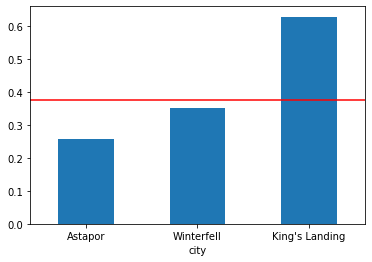

In [13]:
# King's Landing appears to have the highest rate of active users

city_active = users.groupby('city').active.sum() / users.groupby('city').active.count()
city_active.nsmallest().plot(kind='bar')
plt.axhline(active_rate, c='r')
_ = plt.xticks(rotation=0)

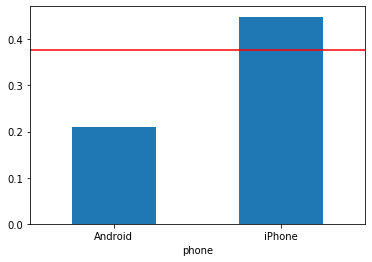

In [14]:
# iPhone Users also appear to have a higher active rate at first glance.

phone_active = users.groupby('phone').active.sum() / users.groupby('phone').active.count()
phone_active.nsmallest().plot(kind='bar')
plt.axhline(active_rate, c='r')
_ = plt.xticks(rotation=0)

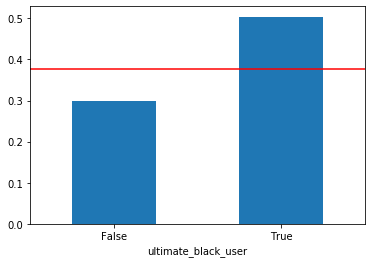

In [15]:
# Ultimate users are more likely to remain active.

ultimate_black_active = users.groupby('ultimate_black_user').active.sum() / users.groupby('ultimate_black_user').active.count()
ultimate_black_active.nsmallest().plot(kind='bar')
plt.axhline(active_rate, c='r')
_ = plt.xticks(rotation=0)

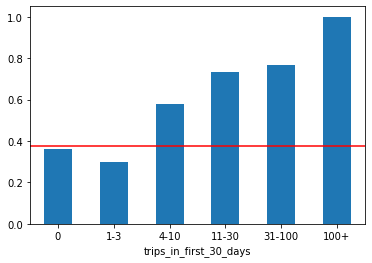

In [16]:
# Going by the number of trips after registration, the more trips a user take, the more likely they will be active. 

bins = pd.IntervalIndex.from_tuples([(-1, 0), (0, 3), (3, 10), (10, 30), (30, 100), (100, 200)])
trips = users.groupby(pd.cut(users.trips_in_first_30_days, bins=bins))

trips_active = trips.active.sum() / trips.active.count()
trips_active.plot(kind='bar')
plt.axhline(active_rate, c='r')
_ = plt.xticks(np.arange(6), ['0', '1-3', '4-10', '11-30', '31-100', '100+'], rotation=0)

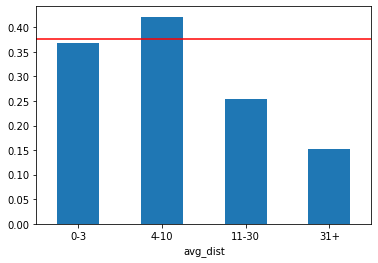

In [17]:
# However, active users are less likely to average long distance.

bins = pd.IntervalIndex.from_tuples([(-1, 3), (3, 10), (10, 30), (30, 200)])
distance = users.groupby(pd.cut(users.avg_dist, bins=bins))

distance_active = distance.active.sum() / distance.active.count()
distance_active.plot(kind='bar')
plt.axhline(active_rate, c='r')
_ = plt.xticks(np.arange(4), ['0-3', '4-10', '11-30', '31+'], rotation=0)

In [18]:
users.dropna(inplace=True)

In [19]:
users = pd.get_dummies(users)

In [20]:
# To train the model, I will use all features that are not datetimes.

COLUMNS = list(set(users.columns) - {'signup_date', 'last_trip_date', 'active'})

In [21]:
# The target variable will be the "active" column, which is either a 0 or a 1.

X = users[COLUMNS]
y = users['active']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [22]:
# I have found that the QuantileTransformer is robust in the presence of outliers.
# However, it can take longer to scale

scaler = QuantileTransformer(output_distribution='normal')
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
# I chose the XGBoost classifier because it gives interpretable results 
# and generally performs well with little tuning.

clf = XGBClassifier(n_jobs=-1, verbosity=1)

clf.fit(X_train_scaled, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=1)

In [24]:
# This function plots the ROC Curve and prints out the F1 score, two metrics useful for determining a model's success.

def plot_classifier(clf, X_train, y_train, X_test, y_test, metric):    
    
    y_pred_train = clf.predict_proba(X_train)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_train)
    
    y_pred_test = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_test)
    
    plt.plot([0, 1], [0, 1], 'k--', label='Coin Flip')
    plt.plot(fpr_train, tpr_train, label='Training Data')
    plt.plot(fpr, tpr, label='Testing Data')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    
    
     
    print(f'Train AUC: {roc_auc_score(y_train, y_pred_train)}, Train F1 Score: {f1_score(y_train, y_pred_train.round())}')
    print(f'Test AUC: {roc_auc_score(y_test, y_pred_test)}, Test F1 Score: {f1_score(y_test, y_pred_test.round())}')
    print(f'Test Accuracy: {accuracy_score(y_test, metric(X_test))}')

Train AUC: 0.9147809077648028, Train F1 Score: 0.7983050206197269
Test AUC: 0.8597178540059918, Test F1 Score: 0.733313014324901
Test Accuracy: 0.7888768247074436


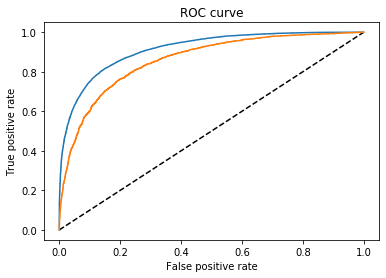

In [25]:
# Out of the box, the XGBoost classifier model has a 78% accuracy on the test set.

plot_classifier(clf, X_train_scaled, y_train, X_test_scaled, y_test, clf.predict)

In [26]:
# The city ended up being the most important feature used by the model.

importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
[(COLUMNS[i], importances[i]) for i in indices]

[("city_King's Landing", 0.29441726),
 ('phone_iPhone', 0.15399596),
 ('avg_rating_by_driver', 0.14950809),
 ('ultimate_black_user', 0.092486985),
 ('surge_pct', 0.083812796),
 ('city_Astapor', 0.067135714),
 ('weekday_pct', 0.047789823),
 ('trips_in_first_30_days', 0.031556558),
 ('avg_surge', 0.02458963),
 ('avg_rating_of_driver', 0.02387296),
 ('avg_dist', 0.018305095),
 ('city_Winterfell', 0.012529075),
 ('phone_Android', 0.0)]

In [27]:
# As a comparison, I'll train a simple neural network to see if it can do any better.

In [28]:
y_train_cat = to_categorical(y_train) 
y_test_cat = to_categorical(y_test)

In [29]:
# Two hidden layers with 50 nodes each.

model = Sequential()

model.add(Dense(50, activation='relu', input_dim=X_train_scaled.shape[1]))
model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [30]:
# categorical_crossentropy works best as a loss function for classification

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
es = EarlyStopping(monitor='val_loss', patience=3)
mc = ModelCheckpoint('../active.h5', monitor='val_loss', save_best_only=True)

history = model.fit(X_train_scaled, y_train_cat, 
          epochs=10, 
          callbacks= [es, mc], 
          batch_size=32,
          validation_data=(X_test_scaled, y_test_cat), 
          shuffle=True)

Epoch 1/10
1037/1037 [==============================] - 1s 1ms/step - loss: 0.5223 - accuracy: 0.7464 - val_loss: 0.4867 - val_accuracy: 0.7651
Epoch 2/10
1037/1037 [==============================] - 1s 782us/step - loss: 0.4956 - accuracy: 0.7629 - val_loss: 0.4921 - val_accuracy: 0.7670
Epoch 3/10
1037/1037 [==============================] - 1s 827us/step - loss: 0.4905 - accuracy: 0.7669 - val_loss: 0.4837 - val_accuracy: 0.7702
Epoch 4/10
1037/1037 [==============================] - 1s 911us/step - loss: 0.4879 - accuracy: 0.7672 - val_loss: 0.4829 - val_accuracy: 0.7680
Epoch 5/10
1037/1037 [==============================] - 1s 810us/step - loss: 0.4845 - accuracy: 0.7691 - val_loss: 0.4776 - val_accuracy: 0.7717
Epoch 6/10
1037/1037 [==============================] - 1s 796us/step - loss: 0.4820 - accuracy: 0.7695 - val_loss: 0.4781 - val_accuracy: 0.7711
Epoch 7/10
1037/1037 [==============================] - 1s 823us/step - loss: 0.4807 - accuracy: 0.7707 - val_loss: 0.4732 - v

In [32]:
best_model = load_model('../active.h5')

Train AUC: 0.8487307276225633, Train F1 Score: 0.7193589647129637
Test AUC: 0.8493810835849986, Test F1 Score: 0.7211378423362083
Test Accuracy: 0.7776571359633249


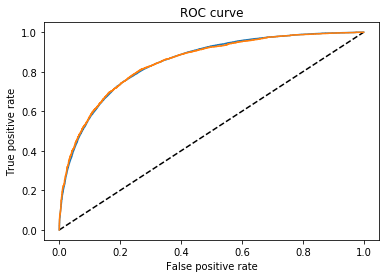

In [36]:
# The XGBoost model performs slightly better than the Neural Net. 

plot_classifier(best_model, X_train_scaled, y_train, X_test_scaled, y_test, best_model.predict_classes)

Both of the models I created were able to predict whether a user would remain active with over a 75% accuracy. Two the most important features used in the XGBoost model were the user's city, and the user's phone model. It would be worthwhile for Ultimate to look into why King's Landing users are more likely to stay active. As for the phone, it seems Android users are far less likely to remain active. I would look into the differences between the Android app and the iPhone app to see if there needs to be any changes to usability.